# Ultimate Data Science Challenge

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import json
import datetime
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

## Part 1 - Exploratory data analysis

>The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [2]:
# Read file in Pandas dataframe
logins = pd.read_json('logins.json')

In [3]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [6]:
# Add a column to count the number of logins and set its value to 1
logins['login_count'] = 1

In [7]:
# Index the dataframe with the datetime of logins
logins.set_index('login_time',inplace=True)

In [8]:
# This function resamples the login counts and plots it
def plot_resample(df,freq):
    df_rspl = df.resample(freq).count()
    plt.figure(figsize=[20,15])
    df_rspl.plot()
    plt.title('login counts with frequency ' + freq)
    plt.show()
    return df_rspl

<Figure size 1440x1080 with 0 Axes>

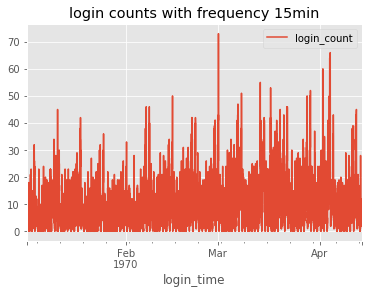

In [9]:
logins15m = plot_resample(logins,'15min')

### Trend

<Figure size 1440x1080 with 0 Axes>

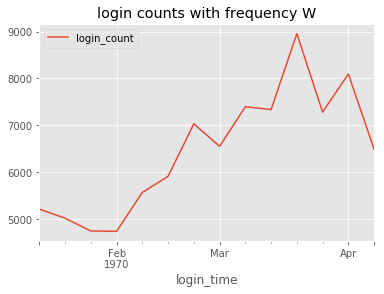

In [10]:
loginsweek = plot_resample(logins['1970-01-05':'1970-04-12'],'W')

This weekly sampling frequency shows the trend over the 3 months of data. It's an increasing trend since February.

There is a peak at mid March. We could investigate this peak: special event? holiday?

### Weekly Seasonality

<Figure size 1440x1080 with 0 Axes>

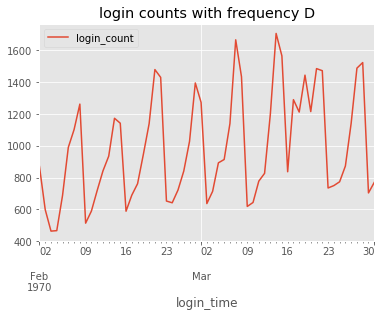

In [11]:
loginsday = plot_resample(logins['1970-02-01':'1970-03-31'],'D')

This daily frequency plot shows a weekly seasonality, with peaks at the end of each week, and valleys on Mondays and Tuesdays.

Week from March 16 to March 23 looks different. Is it due to St Patrick's day on March 17th? Were there festive events that week at this location? 

### Daily Seasonality 

**Week day**

<Figure size 1440x1080 with 0 Axes>

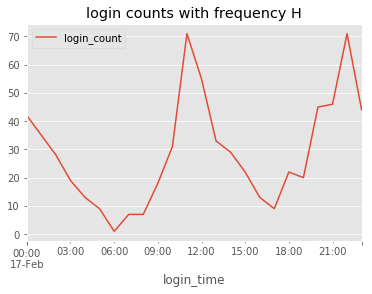

In [12]:
loginshour_weekday = plot_resample(logins['1970-02-17'],'H')

February 17th is a Tuesday. This plot shows daily seasonality, with more logins at lunch time and in the evenings. The peaks are at 11:00am and 10:00pm.

**Week end**

<Figure size 1440x1080 with 0 Axes>

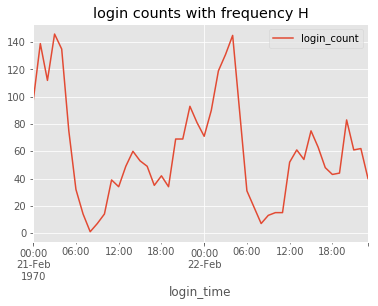

In [13]:
loginshour_weekend = plot_resample(logins['1970-02-21':'1970-02-22'],'H')

February 21st and 22nd are Saturday and Sunday. The weekend daily seasonality is different, with more logins during the night.

## Part 2 - Experiment and metrics design

>The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

>However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

>1.What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

Driver partners tend to be exclusive to each city. This means that the proportion of rides started in Gotham is high for Gotham driver partners and low for Metropolis driver partners.
The objective of this experiment is to reduce the variance of the proportion of rides started in Gotham.

So the key measure of success is to have a lower variance of the proportion of rides started in Gotham.

>2.Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:

>a.how you will implement the experiment

>b.what statistical test(s) you will conduct to verify the significance of the
observation

>c.how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

I would randomly choose driver partners in 2 groups of at least 100 drivers each.
Group A has no toll reimbursement and is the reference group.
Group B has toll reimbursement and is the test group.
I would define a test duration long enough to include weekdays and weekends, and get enough data, so at least two weeks.
I would pick a test time where no special event or holiday happens in any of the two cities.

During the experiment, I would measure for each driver partner the number of rides started in Gotham and the total number of rides.

At the end of the experiment, I would calculate for each driver partner the proportion of rides started in Gotham.

I would make a distribution plot with the proportion of rides started in Gotham on x-axis and the number of driver partners on y-axis for both groups.

The distribution plot is either bimodal or very skewed. If the experiment is successful, I would expect the valley between the 2 peaks to be less deep for group B, and group B should be less skewed than group A.


Make a box plot with group A and group B on x-axis, proportion of rides started in Gotham on y-axis. If the experiment is successful, I would expect the boxes to have the same median, but group B box to be shorter than group A box.

To know if this difference is statistically significant, I would use statistical test for equal variance and hope to reject the null hypothesis that group A and group B have equal variance. I choose a non parametric measure since the distribution is not normal.

## Part 3 ‑ Predictive modeling

>Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

> 1.Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

In [14]:
with open('ultimate_data_challenge.json','r') as json_file:
    riders_dict = json.load(json_file)

In [15]:
riders = pd.DataFrame(riders_dict)

In [16]:
riders.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [17]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [18]:
# Change the type of the timestamps colummns
riders['last_trip_date'] = pd.to_datetime(riders.last_trip_date)
riders['signup_date'] = pd.to_datetime(riders.signup_date)

In [19]:
# Add a column 'active' for users who took a trip in the last 30 days
today = riders.last_trip_date.sort_values()[0]
riders['active'] = 0
riders.active[today - riders.last_trip_date < datetime.timedelta(days=30)] = 1

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [20]:
riders.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


In [21]:
def plot_global(df):
    plt.figure(figsize=(5,5))
    plt.pie(df.active.value_counts().sort_index().values,
            labels=['inactive','active'],colors=['tomato','mediumseagreen'], 
            autopct='%1.1f%%')
    plt.title('Proportion of retained users')
    plt.show()

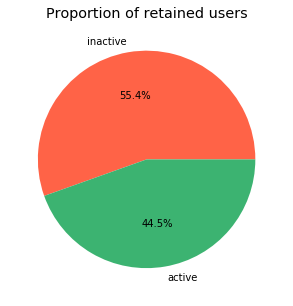

In [22]:
plot_global(riders)

In [23]:
# Plot numeric values and returns t-test for independence between retained and non-retained users
def plot_value(df,col):
    plt.figure(figsize=(5,5))
    sns.violinplot(x=df.active.values, y=df[col].values, 
                   order=[0, 1],
                   palette=['tomato','mediumseagreen'])
    plt.ylabel(col)
    plt.show()
    return ttest_ind(df[df.active==0][col].values, df[df.active==1][col].values, 
                     nan_policy='omit')

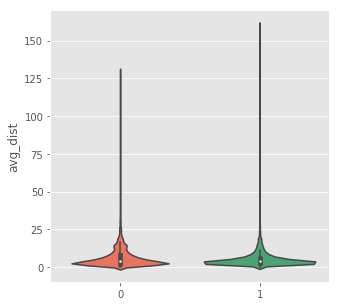

Ttest_indResult(statistic=21.124498873674852, pvalue=1.2800799142182637e-98)

In [24]:
plot_value(riders,'avg_dist')

The average distance is different for users who are retained. It's worth investigating deeper to see where the difference is:

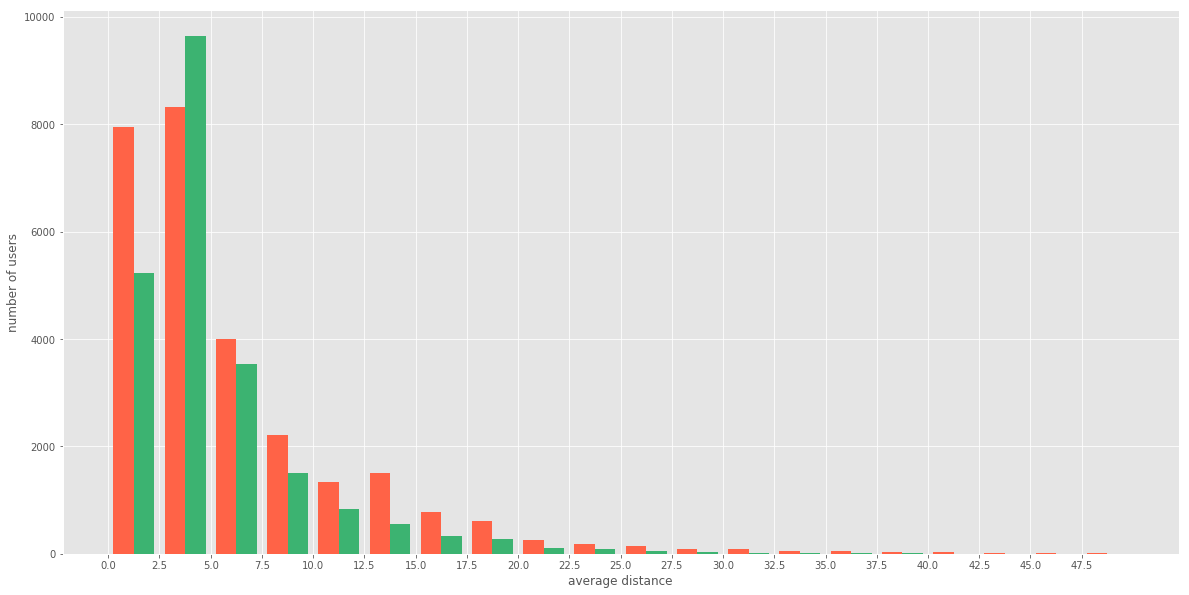

In [25]:
plt.figure(figsize=(20,10))
plt.hist([riders[riders.active==0].avg_dist,riders[riders.active==1].avg_dist],
         color=['tomato','mediumseagreen'],bins=20,range=(0,50))
plt.xticks(np.arange(0,50,2.5))
plt.xlabel('average distance')
plt.ylabel('number of users')
plt.show()

This plot gives a better view of the average distance for retained and non retained users.
We see that the proportion of retained users is high for users whose average distance is between 2.5 and 5 miles.
But the proportion of retained users is low for users whose average distance is below 2.5 miles or over 12.5 miles.

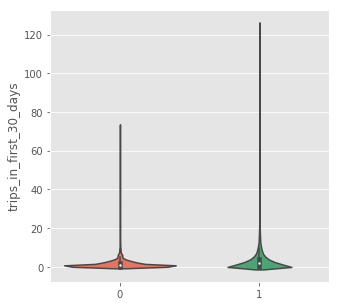

Ttest_indResult(statistic=-41.854673109320856, pvalue=0.0)

In [26]:
plot_value(riders,'trips_in_first_30_days')

The users who quit made very few trips in the first 30 days.

In [27]:
# This function plots 2 pie charts for col=True and col=False
def plot_boolean(df, col):
    plt.figure(figsize=(10,5))
    true_val = df[df[col]==True]['active'].value_counts().sort_index()
    false_val = df[df[col]==False]['active'].value_counts().sort_index()
    
    plt.subplot(1,2,1)
    plt.pie(true_val.values,labels=['inactive','active'],colors=['tomato','mediumseagreen'], autopct='%1.1f%%')
    plt.title(col + ' True')

    plt.subplot(1,2,2)
    plt.pie(false_val.values,labels=['inactive','active'],colors=['tomato','mediumseagreen'], autopct='%1.1f%%')
    plt.title(col + ' False')
    
    plt.show()
    return

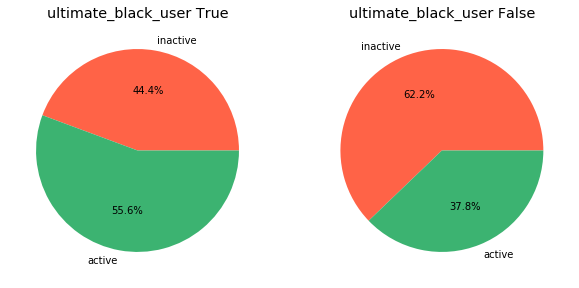

In [28]:
plot_boolean(riders, 'ultimate_black_user')

Ultimate black users are more likely to be retained.

In [29]:
# This function plots a bar chart showing column categories on x-axis and number of users on y-xaxis
def plot_cat(df,col):
    plot_df = df[[col,'active']]
    plot_df['n'] = 1
    plot_df = plot_df.pivot_table(index=col, columns='active', values='n', 
                                  aggfunc='count', fill_value=0)
    plot_df.columns = ['inactive','active']
    ind = np.arange(plot_df.shape[0])
    width = 0.35
    plt.figure(figsize=(5,5))
    plt.bar(ind-width/2, plot_df.inactive.values, width, color='tomato')
    plt.bar(ind+width/2, plot_df.active.values, width, color='mediumseagreen')
    plt.xticks(ind,plot_df.index.values)
    plt.show()
    return

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


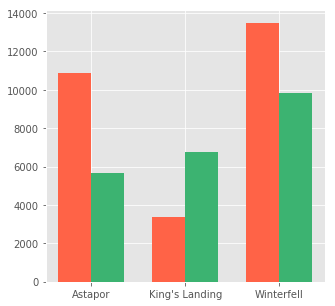

In [30]:
plot_cat(riders,'city')

Users from King's Landing are more likely to be retained.

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


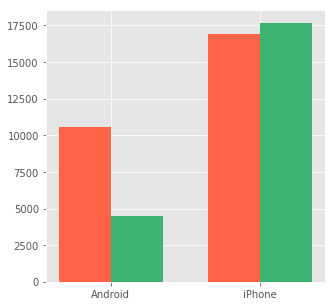

In [31]:
plot_cat(riders,'phone')

Users using Android are more likely to quit.

** Conclusion of the exploratory data analysis:**

44.5% of the users were retained.

The most important features are:

- phone: Android users are more likely to quit than iPhone user. I would suggest to check for usability with Android.

- city: King's Landing users are more likely to be retained. I would suggest to check the reliability and availability of the service in these cities, or if they have different demographics.

- ultimate black users are more likely to be retained. It shows users appreciate this service.

- users with few trips in the first 30 days are more likely to quit. But do they really quit or are they occasional users?

- users with average trip distance between 2.5 and 7.5 miles are more likely to be retained.

There are missing values in the columns avg_rating_by_driver and avg_rating_of_driver. I will replace the missing values with the mean of each column.

In [32]:
m = np.mean(riders[riders.avg_rating_by_driver.notna()].avg_rating_by_driver)
riders.avg_rating_by_driver.fillna(m, inplace=True)

m = np.mean(riders[riders.avg_rating_of_driver.notna()].avg_rating_of_driver)
riders.avg_rating_of_driver.fillna(m, inplace=True)

There are missing values in phone column.

I will drop the rows with missing phone value for 3 reasons:

- There are only 400 missing values
- This feature is important to know if the user is active
- There is no way to guess or approximate the missing value

In [33]:
riders.dropna(axis='index', inplace=True)
riders.reset_index(drop=True, inplace=True)

>2.Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.

First, I need to transform the data.
I will use one hot encoding for the categorical columns city and phone.

In [34]:
riders.city = riders.city.astype('category')
riders.phone = riders.phone.astype('category')

In [35]:
riders_ohe = pd.get_dummies(riders, columns=['city','phone'])

This is a classification problem, where 'active' is the label to predict.
I will separate the features X from the label y

In [36]:
X = riders_ohe.drop(columns=['last_trip_date','signup_date','active',
                             'city_King\'s Landing','phone_Android'])
y = riders_ohe.active

In [37]:
X.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,city_Astapor,city_Winterfell,phone_iPhone
count,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000
mean,5.785418,4.777862,4.601482,1.074991,8.875314,2.277256,60.883832,0.330881,0.466192,0.697162
std,5.669709,0.446220,0.565227,0.222666,19.989018,3.793300,37.086239,0.470535,0.498861,0.459491
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.500000,1.000000,0.000000,0.000000,33.300000,0.000000,0.000000,0.000000
50%,3.880000,5.000000,4.700000,1.000000,0.000000,1.000000,66.700000,0.000000,0.000000,1.000000
75%,6.930000,5.000000,5.000000,1.050000,8.700000,3.000000,100.000000,1.000000,1.000000,1.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000,1.000000,1.000000,1.000000


Some models need scaled data to work well, so I will use StandardScaler

In [38]:
col_to_scale = ['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge',
                'surge_pct', 'trips_in_first_30_days','weekday_pct']
scaler = StandardScaler()
XS_array = scaler.fit_transform(X[col_to_scale].astype('float'))
XS = pd.DataFrame(XS_array,columns=col_to_scale)
XS = pd.concat([X.drop(columns=col_to_scale), XS], axis='columns')

In [39]:
X.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,city_Astapor,city_Winterfell,phone_iPhone
count,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000
mean,5.785418,4.777862,4.601482,1.074991,8.875314,2.277256,60.883832,0.330881,0.466192,0.697162
std,5.669709,0.446220,0.565227,0.222666,19.989018,3.793300,37.086239,0.470535,0.498861,0.459491
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.500000,1.000000,0.000000,0.000000,33.300000,0.000000,0.000000,0.000000
50%,3.880000,5.000000,4.700000,1.000000,0.000000,1.000000,66.700000,0.000000,0.000000,1.000000
75%,6.930000,5.000000,5.000000,1.050000,8.700000,3.000000,100.000000,1.000000,1.000000,1.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000,1.000000,1.000000,1.000000


I will split my data into training and test.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)
XS_train, XS_test, ys_train, ys_test = train_test_split(XS, y, test_size=0.2, random_state=14)

I will use accuracy score metrics to measure the performance of my models.

To compare the performance of my models, I will compute the performance of a dummy model (random pick of labels)

In [41]:
dum = DummyClassifier(random_state=14)
dum.fit(X_train, y_train)
score_dum = dum.score(X_test, y_test)
print('Score for dummy model: ',score_dum)

Score for dummy model:  0.4995464166918657


First, let's try a simple linear model: LogisticRegression. This model is based on distance, so it's better to use scaled data.

In [54]:
lr = LogisticRegression(solver='liblinear')
lr.fit(XS_train, y_train)
score_lr = lr.score(XS_test, y_test)
print('Score for Logistic Regression Model: ',score_lr)

Score for Logistic Regression Model:  0.6849107952827336


Now, let's try a more complex model: K nearest neighbors classifier. This model is based on distance, so it's better to use scaled data.

In [55]:
knn = KNeighborsClassifier()
knn.fit(XS_train, y_train)
score_knn = knn.score(XS_test, y_test)
print('Score for K Nearest Neighbors Model: ',score_knn)

Score for K Nearest Neighbors Model:  0.7272452373752646


This model has a better score.

Let's try an even more complex model: Support Vector Classifier. This model is based on distnace, so it's better to use scaled data.

In [58]:
svc = SVC(gamma='scale')
svc.fit(XS_train, y_train)
score_svc = svc.score(XS_test, y_test)
print('Score for Support Vector Classifier: ', score_svc)

Score for Support Vector Classifier:  0.7554681987702853


In [45]:
svc

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Let's try an ensemble model: Random Forest. This model is not based on distance, so we don't need to use scaled data.

In [59]:
rf = RandomForestClassifier(n_estimators=100, random_state=14)
rf.fit(X_train, y_train)
score_rf = rf.score(X_test, y_test)
print('Score for Random Forest: ', score_rf)

Score for Random Forest:  0.7424654772704364


The best model is Support Vector Classifier. Now, we can improve its performance by tuning the hyper parameters: C, gamma, kernel type.

In [47]:
def cross_validation(model, XS_train, y_train):
    """This function uses KFold to compute accuracy score of model"""
    print('Model Cross Validation in progress')
    n_splits=3
    scores = []
    kf = KFold(n_splits=n_splits)
    for train_idx, test_idx in kf.split(XS_train, y_train):
        XKF_train, XKF_test = XS_train.iloc[train_idx], XS_train.iloc[test_idx]
        ykf_train, ykf_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
        model.fit(XKF_train, ykf_train)
        scores.append(model.score(XKF_test, ykf_test))
    return(np.sum(scores)/n_splits)

First, try different kernels

In [48]:
grid = ['linear', 'rbf', 'poly', 'sigmoid']
for p in grid:
    model = SVC(gamma='scale', kernel=p)
    score = cross_validation(model, XS_train, y_train)
    print('Score for {first} : {second}'.format(first=p, second=score))

Model Cross Validation in progress
Score for linear : 0.651664529155851
Model Cross Validation in progress
Score for rbf : 0.746616989724989
Model Cross Validation in progress
Score for poly : 0.7089181120402857
Model Cross Validation in progress
Score for sigmoid : 0.477106060460232


rbf kernel gives best results.
Now, I will tune C.

In [49]:
grid = [1.8, 2, 2.2, 2.4]
for p in grid:
    model = SVC(gamma='scale', C=p)
    score = cross_validation(model, XS_train, y_train)
    print('Score for {first} : {second}'.format(first=p, second=score))

Model Cross Validation in progress
Score for 1.8 : 0.7473729619052129
Model Cross Validation in progress
Score for 2 : 0.7476501612302472
Model Cross Validation in progress
Score for 2.2 : 0.747171367418696
Model Cross Validation in progress
Score for 2.4 : 0.7470453720553255


The best value for C is 2. Now, I try to optimize gamma. 

In [50]:
grid = [0.06, 0.08, 0.1, 0.12, 0.14]
for p in grid:
    model = SVC(gamma=p, C=2)
    score = cross_validation(model, XS_train, y_train)
    print('Score for {first} : {second}'.format(first=p, second=score))

Model Cross Validation in progress
Score for 0.06 : 0.746516166762559
Model Cross Validation in progress
Score for 0.08 : 0.7478265509287185
Model Cross Validation in progress
Score for 0.1 : 0.7474989572685834
Model Cross Validation in progress
Score for 0.12 : 0.7470957530545593
Model Cross Validation in progress
Score for 0.14 : 0.7467177421978378


The best value for gamma is 0.08

Now, I can try my optimized model on the test data.

In [51]:
svc = SVC(gamma=0.08, C=2)
svc.fit(XS_train, y_train)
score_svc = svc.score(XS_test, y_test)
print('Score for Support Vector Classifier: ', score_svc)

Score for Support Vector Classifier:  0.7564761616772503


>3.Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

Ultimate can use the result of the exploratory data analysis to find the reasons why riders quit.
From the model predictions, Ultimate can focus their customer care on the users who are likely to quit:
- ask them feedback about the service
- give them special offer for their next ride